# Image generation with DeciDiffusion and OpenVINO

DeciDiffusion 1.0 is a diffusion-based text-to-image generation model. While it maintains foundational architecture elements from Stable Diffusion, such as the Variational Autoencoder (VAE) and CLIP's pre-trained Text Encoder, DeciDiffusion introduces significant enhancements. The primary innovation is the substitution of U-Net with the more efficient U-Net-NAS, a design pioneered by Deci. This novel component streamlines the model by reducing the number of parameters, leading to superior computational efficiency.

The domain of text-to-image generation, with its transformative potential in design, art, and advertising, has captivated both experts and laypeople. This technology’s allure lies in its ability to effortlessly transform text into vivid images, marking a significant leap in AI capabilities. While Stable Diffusion’s open-source foundation has spurred many advancements, it grapples with practical deployment challenges due to its heavy computational needs. These challenges lead to notable latency and cost concerns in training and deployment. In contrast, DeciDiffusion stands out. Its superior computational efficiency ensures a smoother user experience and boasts an impressive reduction of nearly 66% in production costs.

In this tutorial we consider how to convert and run DeciDiffusion using OpenVINO, making text-to-image generative applications more accessible and feasible.

The notebook contains the following steps:

1. Convert PyTorch models to OpenVINO Intermediate Representation using OpenVINO Converter Tool (OVC).
2. Prepare Inference Pipeline.
3. Run Inference pipeline with OpenVINO.
4. Run Interactive demo for DeciDiffusion model

#### Table of contents:
- [Prerequisites](#Prerequisites)
- [Prepare DeciDiffusion models for OpenVINO format conversion](#Prepare-DeciDiffusion-models-for-OpenVINO-format-conversion)
    - [About model](#About-model)
    - [DeciDiffusion integration with Diffusers library](#DeciDiffusion-integration-with-Diffusers-library)
- [Convert models to OpenVINO format](#Convert-models-to-OpenVINO-format)
    - [Text Encoder](#Text-Encoder)
    - [U-Net NAS](#U-Net-NAS)
    - [VAE](#VAE)
- [Prepare inference pipeline](#Prepare-inference-pipeline)
    - [Guidance scale and negative prompt for controlling generation result.](#Guidance-scale-and-negative-prompt-for-controlling-generation-result.)
    - [Strength for controlling Image-to-Image generation](#Strength-for-controlling-Image-to-Image-generation)
    - [Configure Inference Pipeline](#Configure-Inference-Pipeline)
- [Text-to-Image generation](#Text-to-Image-generation)
    - [Image-to-Image generation](#Image-to-Image-generation)
- [Interactive demo](#Interactive-demo)


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

install required packages

In [1]:
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu  "diffusers" "transformers" "torch" "pillow" "openvino>=2023.1.0" "gradio"

## Prepare DeciDiffusion models for OpenVINO format conversion
[back to top ⬆️](#Table-of-contents:)

### About model
[back to top ⬆️](#Table-of-contents:)

DeciDiffusion 1.0 is an 820 million parameter text-to-image latent diffusion model trained on the LAION-v2 dataset and fine-tuned on the LAION-ART dataset. It's architecture based on Stable Diffusion foundational model with the replacement of the traditional U-Net component with a more streamlined variant, U-Net-NAS, conceived by Deci.

To understand the role and significance of the the U-Net component, it’s worth diving into the latent diffusion architecture:

Latent diffusion starts with a rudimentary, “noisy” image representation in latent space. With textual guidance, like “A drawing of a pint of beer on a brick wall,” the model progressively refines this representation, gradually unveiling a denoised image representation. After sufficient iterations, this representation in latent space is expanded into a high-resolution image.

Latent diffusion comprises three primary components:

* **Variational Autoencoder (VAE)**: Transforms images into latent representations and vice versa. During training, the encoder converts an image into a latent version, while the decoder reverses this during both training and inference.

* **U-Net**: An iterative encoder-decoder mechanism that introduces and subsequently reduces noise in the latent images. The decoder employs cross-attention layers, conditioning output on text embeddings linked to the given text description.

* **Text Encoder**: This component transforms textual prompts into latent text embeddings, which the U-Net decoder uses.

U-Net is a resource-intensive component during training and inference. The repetitive noising and denoising processes incur substantial computational costs at every iteration.

![unet-vs-unet-nas](https://deci.ai/wp-content/uploads/2023/09/U-Net-NAS-1024x632.png)

U-Net-NAS features two fewer up and down blocks than U-Net. Its distinctive feature is the variable composition of each block, where the number of ResNet and Attention blocks is optimized to achieve the best overall model performance using the fewest computations. With DeciDiffusion's incorporation of U-Net-NAS — characterized by fewer parameters and enhanced computational efficiency — the overall model’s computational demands are reduced. 

### DeciDiffusion integration with Diffusers library
[back to top ⬆️](#Table-of-contents:)

To work with DeciDiffusion, we will use Hugging Face [Diffusers](https://github.com/huggingface/diffusers) library. DeciDiffusion the [`StableDiffusionPipeline`](https://huggingface.co/docs/diffusers/using-diffusers/conditional_image_generation) with small customization: overriding default parameters and replacing U-Net model. The code, defined in `load_orginal_pytorch_pipeline_componets` function, demonstrates how to create diffusers pipeline for DeciDiffusion.

In [2]:
from pathlib import Path
import gc
import torch
import openvino as ov
from diffusers import StableDiffusionPipeline
import warnings

warnings.filterwarnings('ignore')

TEXT_ENCODER_OV_PATH = Path("model/text_encoder.xml")
UNET_OV_PATH = Path('model/unet_nas.xml')
VAE_ENCODER_OV_PATH = Path("model/vae_encoder.xml")
VAE_DECODER_OV_PATH = Path('model/vae_decoder.xml')
checkpoint = "Deci/DeciDiffusion-v1-0"
scheduler_config_dir = Path("model/scheduler")
tokenizer_dir = Path("model/tokenizer")

def load_orginal_pytorch_pipeline_componets():
    pipeline = StableDiffusionPipeline.from_pretrained(checkpoint, custom_pipeline=checkpoint, torch_dtype=torch.float32)
    pipeline.unet = pipeline.unet.from_pretrained(checkpoint, subfolder='flexible_unet', torch_dtype=torch.float32)
    text_encoder = pipeline.text_encoder
    text_encoder.eval()
    unet = pipeline.unet
    unet.eval()
    vae = pipeline.vae
    vae.eval()

    del pipeline
    gc.collect();
    return text_encoder, unet, vae
    

def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()


skip_conversion = TEXT_ENCODER_OV_PATH.exists() and UNET_OV_PATH.exists() and VAE_ENCODER_OV_PATH.exists() and VAE_DECODER_OV_PATH.exists()

if not skip_conversion:
    text_encoder, unet, vae = load_orginal_pytorch_pipeline_componets()
else:
    text_encoder, unet, vae = None, None, None

2023-10-13 18:51:04.214433: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-13 18:51:04.252034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 18:51:04.947207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Convert models to OpenVINO format
[back to top ⬆️](#Table-of-contents:)

Starting from 2023.0 release, OpenVINO supports PyTorch models directly via Model Conversion API. `ov.convert_model` function accepts instance of PyTorch model and example inputs for tracing and returns object of `ov.Model` class, ready to use or save on disk using `ov.save_model` function. 


As we already discussed above, the pipeline consists of three important parts:

* Text Encoder to create condition to generate an image from a text prompt.
* U-Net-NAS for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.

Let us convert each part:

### Text Encoder
[back to top ⬆️](#Table-of-contents:)

The text-encoder is responsible for transforming the input prompt, for example, "a photo of an astronaut riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.

Input of the text encoder is the tensor `input_ids` which contains indexes of tokens from text processed by tokenizer and padded to maximum length accepted by model. Model outputs are two tensors: `last_hidden_state` - hidden state from the last MultiHeadAttention layer in the model and `pooler_out` - Pooled output for whole model hidden states.

In [3]:
def convert_encoder(text_encoder: torch.nn.Module, ir_path:Path):
    """
    Convert Text Encoder mode. 
    Function accepts text encoder model, and prepares example inputs for conversion, 
    Parameters: 
        text_encoder (torch.nn.Module): text_encoder model from Stable Diffusion pipeline
        ir_path (Path): File for storing model
    Returns:
        None
    """
    input_ids = torch.ones((1, 77), dtype=torch.long)
    # switch model to inference mode
    text_encoder.eval()

    # disable gradients calculation for reducing memory consumption
    with torch.no_grad():
        # Export model to IR format
        ov_model = ov.convert_model(text_encoder, example_input=input_ids, input=[(1,77),])
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    gc.collect();
    print(f'Text Encoder successfully converted to IR and saved to {ir_path}')
    

if not TEXT_ENCODER_OV_PATH.exists():
    convert_encoder(text_encoder, TEXT_ENCODER_OV_PATH)
else:
    print(f"Text encoder will be loaded from {TEXT_ENCODER_OV_PATH}")

del text_encoder
gc.collect();

Text encoder will be loaded from model/text_encoder.xml


### U-Net NAS
[back to top ⬆️](#Table-of-contents:)

U-Net NAS model, similar to Stable Diffusion UNet model, has three inputs:

* `sample` - latent image sample from previous step. Generation process has not been started yet, so you will use random noise.
* `timestep` - current scheduler step.
* `encoder_hidden_state` - hidden state of text encoder.

Model predicts the `sample` state for the next step.

In [4]:
import numpy as np

dtype_mapping = {
    torch.float32: ov.Type.f32,
    torch.float64: ov.Type.f64
}


def convert_unet(unet:torch.nn.Module, ir_path:Path):
    """
    Convert U-net model to IR format. 
    Function accepts unet model, prepares example inputs for conversion, 
    Parameters: 
        unet (StableDiffusionPipeline): unet from Stable Diffusion pipeline
        ir_path (Path): File for storing model
    Returns:
        None
    """
    # prepare inputs
    encoder_hidden_state = torch.ones((2, 77, 768))
    latents_shape = (2, 4, 512 // 8, 512 // 8)
    latents = torch.randn(latents_shape)
    t = torch.from_numpy(np.array(1, dtype=float))
    dummy_inputs = (latents, t, encoder_hidden_state)
    input_info = []
    for i, input_tensor in enumerate(dummy_inputs):
        shape = ov.PartialShape(tuple(input_tensor.shape))
        if i != 1:
            shape[0] = -1
        element_type = dtype_mapping[input_tensor.dtype]
        input_info.append((shape, element_type))

    unet.eval()
    with torch.no_grad():
        ov_model = ov.convert_model(unet, example_input=dummy_inputs, input=input_info)
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    gc.collect();
    print(f'U-Net NAS successfully converted to IR and saved to {ir_path}')


if not UNET_OV_PATH.exists():
    convert_unet(unet, UNET_OV_PATH)
else:
    print(f"U-Net NAS will be loaded from {UNET_OV_PATH}")
del unet
gc.collect();

U-Net NAS will be loaded from model/unet_nas.xml


### VAE
[back to top ⬆️](#Table-of-contents:)

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net model. The decoder, conversely, transforms the latent representation back into an image.

During latent diffusion training, the encoder is used to get the latent representations (latents) of the images for the forward diffusion process, which applies more and more noise at each step. During inference, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. When you run inference for text-to-image, there is no initial image as a starting point. You can skip this step and directly generate initial random noise.

As the encoder and the decoder are used independently in different parts of the pipeline, it will be better to convert them to separate models.

In [5]:
def convert_vae_encoder(vae: torch.nn.Module, ir_path: Path):
    """
    Convert VAE model for encoding to IR format. 
    Function accepts vae model, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for conversion, 
    Parameters: 
        vae (torch.nn.Module): VAE model from StableDiffusio pipeline 
        ir_path (Path): File for storing model
    Returns:
        None
    """
    class VAEEncoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, image):
            return self.vae.encode(x=image)["latent_dist"].sample()
    vae_encoder = VAEEncoderWrapper(vae)
    vae_encoder.eval()
    image = torch.zeros((1, 3, 512, 512))
    with torch.no_grad():
        ov_model = ov.convert_model(vae_encoder, example_input=image, input=[((1,3,512,512),)])
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    gc.collect();
    print(f'VAE encoder successfully converted to IR and saved to {ir_path}')


if not VAE_ENCODER_OV_PATH.exists():
    convert_vae_encoder(vae, VAE_ENCODER_OV_PATH)
else:
    print(f"VAE encoder will be loaded from {VAE_ENCODER_OV_PATH}")


def convert_vae_decoder(vae: torch.nn.Module, ir_path: Path):
    """
    Convert VAE model for decoding to IR format. 
    Function accepts vae model, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for conversion, 
    Parameters: 
        vae (torch.nn.Module): VAE model frm StableDiffusion pipeline
        ir_path (Path): File for storing model
    Returns:
        None
    """
    class VAEDecoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, latents):
            return self.vae.decode(latents)
    
    vae_decoder = VAEDecoderWrapper(vae)
    latents = torch.zeros((1, 4, 64, 64))

    vae_decoder.eval()
    with torch.no_grad():
        ov_model = ov.convert_model(vae_decoder, example_input=latents, input=[((1,4,64,64),)])
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    gc.collect();
    print(f'VAE decoder successfully converted to IR and saved to {ir_path}')


if not VAE_DECODER_OV_PATH.exists():
    convert_vae_decoder(vae, VAE_DECODER_OV_PATH)
else:
    print(f"VAE decoder will be loaded from {VAE_DECODER_OV_PATH}")

del vae
gc.collect();

VAE encoder will be loaded from model/vae_encoder.xml
VAE decoder will be loaded from model/vae_decoder.xml


## Prepare inference pipeline
[back to top ⬆️](#Table-of-contents:)

Putting it all together, let us now take a closer look at how the model works in inference by illustrating the logical flow.
![sd-pipeline](https://user-images.githubusercontent.com/29454499/260981188-c112dd0a-5752-4515-adca-8b09bea5d14a.png)

As you can see from the diagram, the only difference between Text-to-Image and text-guided Image-to-Image generation in approach is how initial latent state is generated. In case of Image-to-Image generation, you additionally have an image encoded by VAE encoder mixed with the noise produced by using latent seed, while in Text-to-Image you use only noise as initial latent state.
The stable diffusion model takes both a latent image representation of size $64 \times 64$ and a text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder as an input.

Next, the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons.
More information about supported schedulers algorithms can be found in [diffusers documentation](https://huggingface.co/docs/diffusers/main/en/using-diffusers/schedulers).

Theory on how the scheduler algorithm function works is out of scope for this notebook. Nonetheless, in short, you should remember that you compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, refer to the recommended [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated given number of times (by default 30 for DeciDiffusion) to step-by-step retrieve better latent image representations.
When complete, the latent image representation is decoded by the decoder part of the variational auto encoder.

### Guidance scale and negative prompt for controlling generation result.
[back to top ⬆️](#Table-of-contents:)

Guidance scale controls how similar the generated image will be to the prompt. A higher guidance scale means the model will try to generate an image that follows the prompt more strictly. A lower guidance scale means the model will have more creativity.
guidance_scale is a way to increase the adherence to the conditional signal that guides the generation (text, in this case) as well as overall sample quality. It is also known as [classifier-free guidance](https://arxiv.org/abs/2207.12598). The default guidance scale in DeciDiffusion is 0.7.

Additionally, to improve image generation quality, model supports negative prompting. Technically, positive prompt steers the diffusion toward the images associated with it, while negative prompt steers the diffusion away from it.In other words, negative prompt declares undesired concepts for generation image, e.g. if we want to have colorful and bright image, gray scale image will be result which we want to avoid, in this case gray scale can be treated as negative prompt. The positive and negative prompt are in equal footing. You can always use one with or without the other. More explanation of how it works can be found in this [article](https://stable-diffusion-art.com/how-negative-prompt-work/).

**Note**: negative prompting applicable only for high guidance scale (at least > 1).

### Strength for controlling Image-to-Image generation
[back to top ⬆️](#Table-of-contents:)

In the Image-to-Image mode, the strength parameter plays a crucial role. It determines the level of noise that is added to the initial image while generating a new one. By adjusting this parameter, you can achieve better consistency with the original image and accomplish your creative objectives. It gives you the flexibility to make small alterations or lets you entirely transform the image.

Working with the strength parameter is really straightforward, you only need to remember how the extremes work:

* setting strength close to 0 will produce an image nearly identical to the original,

* setting strength to 1 will produce an image that greatly differs from the original.

For optimal results - combining elements from the original image with the concepts outlined in the prompt, it is best to aim for values between 0.4 and 0.6. 

In [6]:
import inspect
from typing import List, Optional, Union, Dict

import PIL
import cv2

from transformers import CLIPTokenizer
from diffusers.pipelines.pipeline_utils import DiffusionPipeline
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler
from openvino.runtime import Model


def scale_fit_to_window(dst_width:int, dst_height:int, image_width:int, image_height:int):
    """
    Preprocessing helper function for calculating image size for resize with peserving original aspect ratio 
    and fitting image to specific window size
    
    Parameters:
      dst_width (int): destination window width
      dst_height (int): destination window height
      image_width (int): source image width
      image_height (int): source image height
    Returns:
      result_width (int): calculated width for resize
      result_height (int): calculated height for resize
    """
    im_scale = min(dst_height / image_height, dst_width / image_width)
    return int(im_scale * image_width), int(im_scale * image_height)


def preprocess(image: PIL.Image.Image):
    """
    Image preprocessing function. Takes image in PIL.Image format, resizes it to keep aspect ration and fits to model input window 512x512,
    then converts it to np.ndarray and adds padding with zeros on right or bottom side of image (depends from aspect ratio), after that
    converts data to float32 data type and change range of values from [0, 255] to [-1, 1], finally, converts data layout from planar NHWC to NCHW.
    The function returns preprocessed input tensor and padding size, which can be used in postprocessing.
    
    Parameters:
      image (PIL.Image.Image): input image
    Returns:
       image (np.ndarray): preprocessed image tensor
       meta (Dict): dictionary with preprocessing metadata info
    """
    src_width, src_height = image.size
    dst_width, dst_height = scale_fit_to_window(512, 512, src_width, src_height)
    image = np.array(image.resize((dst_width, dst_height),
                     resample=PIL.Image.Resampling.LANCZOS))[None, :]
    pad_width = 512 - dst_width
    pad_height = 512 - dst_height
    pad = ((0, 0), (0, pad_height), (0, pad_width), (0, 0))
    image = np.pad(image, pad, mode="constant")
    image = image.astype(np.float32) / 255.0
    image = 2.0 * image - 1.0
    image = image.transpose(0, 3, 1, 2)
    return image, {"padding": pad, "src_width": src_width, "src_height": src_height}


class OVStableDiffusionPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae_decoder: Model,
        text_encoder: Model,
        tokenizer: CLIPTokenizer,
        unet: Model,
        scheduler: Union[DDIMScheduler, PNDMScheduler, LMSDiscreteScheduler],
        vae_encoder: Model = None,
    ):
        """
        Pipeline for text-to-image generation using Stable Diffusion.
        Parameters:
            vae (Model):
                Variational Auto-Encoder (VAE) Model to decode images to and from latent representations.
            text_encoder (Model):
                Frozen text-encoder. Stable Diffusion uses the text portion of
                [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel), specifically
                the clip-vit-large-patch14(https://huggingface.co/openai/clip-vit-large-patch14) variant.
            tokenizer (CLIPTokenizer):
                Tokenizer of class CLIPTokenizer(https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
            unet (Model): Conditional U-Net architecture to denoise the encoded image latents.
            scheduler (SchedulerMixin):
                A scheduler to be used in combination with unet to denoise the encoded image latents. Can be one of
                DDIMScheduler, LMSDiscreteScheduler, or PNDMScheduler.
        """
        super().__init__()
        self.scheduler = scheduler
        self.vae_decoder = vae_decoder
        self.vae_encoder = vae_encoder
        self.text_encoder = text_encoder
        self.unet = unet
        self._text_encoder_output = text_encoder.output(0)
        self._unet_output = unet.output(0)
        self._vae_d_output = vae_decoder.output(0)
        self._vae_e_output = vae_encoder.output(0) if vae_encoder is not None else None
        self.height = 512
        self.width = 512
        self.tokenizer = tokenizer

    def __call__(
        self,
        prompt: Union[str, List[str]],
        image: PIL.Image.Image = None,
        num_inference_steps: Optional[int] = 30,
        negative_prompt: Union[str, List[str]] = None,
        guidance_scale: Optional[float] = 0.7,
        eta: Optional[float] = 0.0,
        output_type: Optional[str] = "pil",
        seed: Optional[int] = None,
        strength: float = 1.0,
        gif: Optional[bool] = False,
        **kwargs,
    ):
        """
        Function invoked when calling the pipeline for generation.
        Parameters:
            prompt (str or List[str]):
                The prompt or prompts to guide the image generation.
            image (PIL.Image.Image, *optional*, None):
                 Intinal image for generation.
            num_inference_steps (int, *optional*, defaults to 30):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            negative_prompt (str or List[str]):
                The negative prompt or prompts to guide the image generation.
            guidance_scale (float, *optional*, defaults to 0.7):
                Guidance scale as defined in Classifier-Free Diffusion Guidance(https://arxiv.org/abs/2207.12598).
                guidance_scale is defined as `w` of equation 2.
                Higher guidance scale encourages to generate images that are closely linked to the text prompt,
                usually at the expense of lower image quality.
            eta (float, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [DDIMScheduler], will be ignored for others.
            output_type (`str`, *optional*, defaults to "pil"):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): PIL.Image.Image or np.array.
            seed (int, *optional*, None):
                Seed for random generator state initialization.
            gif (bool, *optional*, False):
                Flag for storing all steps results or not.
        Returns:
            Dictionary with keys: 
                sample - the last generated image PIL.Image.Image or np.array
                iterations - *optional* (if gif=True) images for all diffusion steps, List of PIL.Image.Image or np.array.
        """
        if seed is not None:
            np.random.seed(seed)

        img_buffer = []
        do_classifier_free_guidance = guidance_scale > 1.0
        # get prompt text embeddings
        text_embeddings = self._encode_prompt(prompt, do_classifier_free_guidance=do_classifier_free_guidance, negative_prompt=negative_prompt)
        
        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        if accepts_offset:
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)
        timesteps, num_inference_steps = self.get_timesteps(num_inference_steps, strength)
        latent_timestep = timesteps[:1]

        # get the initial random noise unless the user supplied it
        latents, meta = self.prepare_latents(image, latent_timestep)

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        for i, t in enumerate(self.progress_bar(timesteps)):
            # expand the latents if you are doing classifier free guidance
            latent_model_input = np.concatenate([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet([latent_model_input, t, text_embeddings])[self._unet_output]
            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(torch.from_numpy(noise_pred), t, torch.from_numpy(latents), **extra_step_kwargs)["prev_sample"].numpy()
            if gif:
                image = self.vae_decoder(latents * (1 / 0.18215))[self._vae_d_output]
                image = self.postprocess_image(image, meta, output_type)
                img_buffer.extend(image)

        # scale and decode the image latents with vae
        image = self.vae_decoder(latents * (1 / 0.18215))[self._vae_d_output]

        image = self.postprocess_image(image, meta, output_type)
        return {"sample": image, 'iterations': img_buffer}
    
    def _encode_prompt(self, prompt:Union[str, List[str]], num_images_per_prompt:int = 1, do_classifier_free_guidance:bool = True, negative_prompt:Union[str, List[str]] = None):
        """
        Encodes the prompt into text encoder hidden states.

        Parameters:
            prompt (str or list(str)): prompt to be encoded
            num_images_per_prompt (int): number of images that should be generated per prompt
            do_classifier_free_guidance (bool): whether to use classifier free guidance or not
            negative_prompt (str or list(str)): negative prompt to be encoded
        Returns:
            text_embeddings (np.ndarray): text encoder hidden states
        """
        batch_size = len(prompt) if isinstance(prompt, list) else 1

        # tokenize input prompts
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        text_input_ids = text_inputs.input_ids

        text_embeddings = self.text_encoder(
            text_input_ids)[self._text_encoder_output]

        # duplicate text embeddings for each generation per prompt
        if num_images_per_prompt != 1:
            bs_embed, seq_len, _ = text_embeddings.shape
            text_embeddings = np.tile(
                text_embeddings, (1, num_images_per_prompt, 1))
            text_embeddings = np.reshape(
                text_embeddings, (bs_embed * num_images_per_prompt, seq_len, -1))

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            max_length = text_input_ids.shape[-1]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            else:
                uncond_tokens = negative_prompt
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="np",
            )

            uncond_embeddings = self.text_encoder(uncond_input.input_ids)[self._text_encoder_output]

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = np.tile(uncond_embeddings, (1, num_images_per_prompt, 1))
            uncond_embeddings = np.reshape(uncond_embeddings, (batch_size * num_images_per_prompt, seq_len, -1))

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = np.concatenate([uncond_embeddings, text_embeddings])

        return text_embeddings


    def prepare_latents(self, image:PIL.Image.Image = None, latent_timestep:torch.Tensor = None):
        """
        Function for getting initial latents for starting generation
        
        Parameters:
            image (PIL.Image.Image, *optional*, None):
                Input image for generation, if not provided randon noise will be used as starting point
            latent_timestep (torch.Tensor, *optional*, None):
                Predicted by scheduler initial step for image generation, required for latent image mixing with nosie
        Returns:
            latents (np.ndarray):
                Image encoded in latent space
        """
        latents_shape = (1, 4, self.height // 8, self.width // 8)
        noise = np.random.randn(*latents_shape).astype(np.float32)
        if image is None:
            # if you use LMSDiscreteScheduler, let's make sure latents are multiplied by sigmas
            if isinstance(self.scheduler, LMSDiscreteScheduler):
                noise = noise * self.scheduler.sigmas[0].numpy()
            return noise, {}
        input_image, meta = preprocess(image)
        latents = self.vae_encoder(input_image)[self._vae_e_output] * 0.18215
        latents = self.scheduler.add_noise(torch.from_numpy(latents), torch.from_numpy(noise), latent_timestep).numpy()
        return latents, meta

    def postprocess_image(self, image:np.ndarray, meta:Dict, output_type:str = "pil"):
        """
        Postprocessing for decoded image. Takes generated image decoded by VAE decoder, unpad it to initila image size (if required), 
        normalize and convert to [0, 255] pixels range. Optionally, convertes it from np.ndarray to PIL.Image format
        
        Parameters:
            image (np.ndarray):
                Generated image
            meta (Dict):
                Metadata obtained on latents preparing step, can be empty
            output_type (str, *optional*, pil):
                Output format for result, can be pil or numpy
        Returns:
            image (List of np.ndarray or PIL.Image.Image):
                Postprocessed images
        """
        if "padding" in meta:
            pad = meta["padding"]
            (_, end_h), (_, end_w) = pad[1:3]
            h, w = image.shape[2:]
            unpad_h = h - end_h
            unpad_w = w - end_w
            image = image[:, :, :unpad_h, :unpad_w]
        image = np.clip(image / 2 + 0.5, 0, 1)
        image = np.transpose(image, (0, 2, 3, 1))
        # 9. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)
            if "src_height" in meta:
                orig_height, orig_width = meta["src_height"], meta["src_width"]
                image = [img.resize((orig_width, orig_height),
                                    PIL.Image.Resampling.LANCZOS) for img in image]
        else:
            if "src_height" in meta:
                orig_height, orig_width = meta["src_height"], meta["src_width"]
                image = [cv2.resize(img, (orig_width, orig_width))
                         for img in image]
        return image

    def get_timesteps(self, num_inference_steps:int, strength:float):
        """
        Helper function for getting scheduler timesteps for generation
        In case of image-to-image generation, it updates number of steps according to strength
        
        Parameters:
           num_inference_steps (int):
              number of inference steps for generation
           strength (float):
               value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. 
               Values that approach 1.0 enable lots of variations but will also produce images that are not semantically consistent with the input.
        """
        # get the original timestep using init_timestep
        init_timestep = min(int(num_inference_steps * strength), num_inference_steps)

        t_start = max(num_inference_steps - init_timestep, 0)
        timesteps = self.scheduler.timesteps[t_start:]

        return timesteps, num_inference_steps - t_start 

### Configure Inference Pipeline
[back to top ⬆️](#Table-of-contents:)


In [7]:
core = ov.Core()

First, you should create instances of OpenVINO Model and compile it using selected device. Select device from dropdown list for running inference using OpenVINO.

In [8]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='CPU',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', options=('CPU', 'GPU', 'AUTO'), value='CPU')

In [9]:
text_enc = core.compile_model(TEXT_ENCODER_OV_PATH, device.value)

In [10]:
unet_model = core.compile_model(UNET_OV_PATH, device.value)

In [11]:
ov_vae_config = {"INFERENCE_PRECISION_HINT": "f32"} if device.value != "CPU" else {}

vae_decoder = core.compile_model(VAE_DECODER_OV_PATH, device.value, ov_vae_config)
vae_encoder = core.compile_model(VAE_ENCODER_OV_PATH, device.value, ov_vae_config)

Model tokenizer and scheduler are also important parts of the pipeline. Let us define them and put all components together

In [12]:
from transformers import AutoTokenizer
from diffusers import DDIMScheduler

if not tokenizer_dir.exists():
    tokenizer = AutoTokenizer.from_pretrained(checkpoint, subfolder='tokenizer')
    tokenizer.save_pretrained(tokenizer_dir)
else:
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_dir)

if not scheduler_config_dir.exists():
    scheduler = DDIMScheduler.from_pretrained(checkpoint, subfolder="scheduler")
    scheduler.save_pretrained(scheduler_config_dir)
else:
    scheduler = DDIMScheduler.from_pretrained(scheduler_config_dir)

ov_pipe = OVStableDiffusionPipeline(
    tokenizer=tokenizer,
    text_encoder=text_enc,
    unet=unet_model,
    vae_encoder=vae_encoder,
    vae_decoder=vae_decoder,
    scheduler=scheduler
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Text-to-Image generation
[back to top ⬆️](#Table-of-contents:)

Now, let's see model in action

In [13]:
text_prompt = 'Highly detailed portrait of a small, adorable cat with round, expressive eyes and a friendly smile'
num_steps = 30
seed = 4217

In [14]:
print('Pipeline settings')
print(f'Input text: {text_prompt}')
print(f'Seed: {seed}')
print(f'Number of steps: {num_steps}')

Pipeline settings
Input text: Highly detailed portrait of a small, adorable cat with round, expressive eyes and a friendly smile
Seed: 4217
Number of steps: 30


In [15]:
result = ov_pipe(text_prompt, num_inference_steps=num_steps, seed=seed)

  0%|          | 0/30 [00:00<?, ?it/s]

Input text:
	Highly detailed portrait of a small, adorable cat with round, expressive eyes and a friendly smile


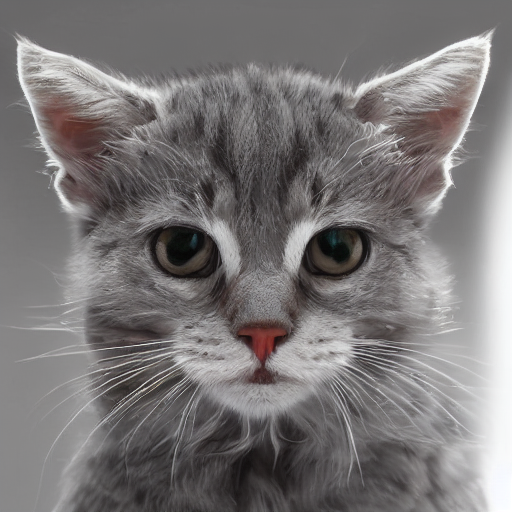

In [16]:
text = '\n\t'.join(text_prompt.split('.'))
print("Input text:")
print("\t" + text)
display(result['sample'][0])

### Image-to-Image generation
[back to top ⬆️](#Table-of-contents:)

One of the most amazing features of Stable Diffusion model is the ability to condition image generation from an existing image or sketch. Given a (potentially crude) image and the right text prompt, latent diffusion models can be used to “enhance” an image.

Pipeline settings
Input text: Highly detailed realistic portrait of a grumpy small, adorable cat with round, expressive eyes
Seed: 4217
Number of steps: 15
Strength: 0.87
Guidance scale: 7.5


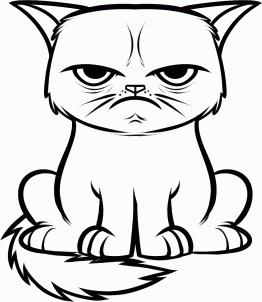

In [17]:
from diffusers.utils import load_image
default_image_url = "https://user-images.githubusercontent.com/29454499/274843996-b0d97f9b-7bfb-4d33-a6d8-d1822eec41ce.jpg"
text_i2i_prompt = 'Highly detailed realistic portrait of a grumpy small, adorable cat with round, expressive eyes'
strength = 0.87
guidance_scale = 7.5
num_i2i_steps = 15
seed_i2i = seed

image = load_image(default_image_url)
print('Pipeline settings')
print(f'Input text: {text_i2i_prompt}')
print(f'Seed: {seed_i2i}')
print(f'Number of steps: {num_i2i_steps}')
print(f"Strength: {strength}")
print(f"Guidance scale: {guidance_scale}")
display(image)

In [18]:
result = ov_pipe(text_i2i_prompt, image, guidance_scale=guidance_scale, strength=strength, num_inference_steps=num_i2i_steps, seed=seed_i2i)

  0%|          | 0/13 [00:00<?, ?it/s]

Input text:
	Highly detailed realistic portrait of a grumpy small, adorable cat with round, expressive eyes


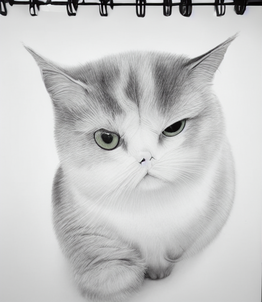

In [19]:
text = '\n\t'.join(text_i2i_prompt.split('.'))
print("Input text:")
print("\t" + text)
display(result['sample'][0])

## Interactive demo
[back to top ⬆️](#Table-of-contents:)


In [ ]:
import gradio as gr

sample_img_url = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/tower.jpg"

img = load_image(sample_img_url).save("tower.jpg")

def generate_from_text(text, negative_prompt, seed, num_steps, guidance_scale, _=gr.Progress(track_tqdm=True)):
    result = ov_pipe(text, negative_prompt=negative_prompt, num_inference_steps=num_steps, seed=seed, guidance_scale=guidance_scale)
    return result["sample"][0]


def generate_from_image(img, text, negative_prompt, seed, num_steps, strength, guidance_scale, _=gr.Progress(track_tqdm=True)):
    result = ov_pipe(text, img, negative_prompt=negative_prompt, num_inference_steps=num_steps, seed=seed, strength=strength, guidance_scale=guidance_scale)
    return result["sample"][0]


with gr.Blocks() as demo:
    with gr.Tab("Text-to-Image generation"):
        with gr.Row():
            with gr.Column():
                text_input = gr.Textbox(lines=3, label="Positive prompt")
                neg_text_input = gr.Textbox(lines=3, label="Negative prompt")
                seed_input = gr.Slider(0, 10000000, value=751, label="Seed")
                steps_input = gr.Slider(1, 50, value=20, step=1, label="Steps")
                guidance_scale = gr.Slider(label="Guidance Scale", minimum=0, maximum=50, value=0.7, step=0.1)
            out = gr.Image(label="Result", type="pil")
        sample_text = "futuristic synthwave city, retro sunset, crystals, spires, volumetric lighting, studio Ghibli style, rendered in unreal engine with clean details"
        sample_text2 = "Highly detailed realistic portrait of a grumpy small, adorable cat with round, expressive eyes"
        btn = gr.Button()
        btn.click(generate_from_text, [text_input, neg_text_input, seed_input, steps_input, guidance_scale], out)
        gr.Examples([[sample_text, "", 42, 20, 0.7], [sample_text2, "", 4218, 20, 0.7]], [text_input, neg_text_input, seed_input, steps_input, guidance_scale])
    with gr.Tab("Image-to-Image generation"):
        with gr.Row():
            with gr.Column():
                i2i_input = gr.Image(label="Image", type="pil")
                i2i_text_input = gr.Textbox(lines=3, label="Text")
                i2i_neg_text_input = gr.Textbox(lines=3, label="Negative prompt")
                i2i_seed_input = gr.Slider(0, 10000000, value=42, label="Seed")
                i2i_steps_input = gr.Slider(1, 50, value=10, step=1, label="Steps")
                strength_input = gr.Slider(0, 1, value=0.5, label="Strength")
                i2i_guidance_scale = gr.Slider(label="Guidance Scale", minimum=0, maximum=50, value=0.7, step=0.1)
            i2i_out = gr.Image(label="Result", type="pil")
        i2i_btn = gr.Button()
        sample_i2i_text = "amazing watercolor painting"
        i2i_btn.click(
            generate_from_image,
            [i2i_input, i2i_text_input, i2i_neg_text_input, i2i_seed_input, i2i_steps_input, strength_input, i2i_guidance_scale],
            i2i_out,
        )
        gr.Examples(
            [["tower.jpg", sample_i2i_text, "", 6400023, 30, 0.6, 5]],
            [i2i_input, i2i_text_input, i2i_neg_text_input, i2i_seed_input, i2i_steps_input, strength_input, i2i_guidance_scale],
            
        )

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/